In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from classification import compute_accuracy
from classification import LogisticRegression, KNN
from regression import compute_error, fill_in_missing_values, get_data, grid_search, unnormalize
from regression import LinearRegression, KNNRegression

pd.set_option('display.max_rows', 500)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Task 0. Explore the dataset

In [44]:
data = pd.read_csv('./data/Mușat_F_Andreea_Alexandra_train.csv')

print('Number of data rows: {}'.format(len(data)))
print('Columns are: {}'.format(data.columns))

data.sample(n=5)

Number of data rows: 1000
Columns are: Index(['Breed Name', 'Weight(g)', 'Height(cm)', 'Longevity(yrs)',
       'Energy level', 'Attention Needs', 'Coat Lenght', 'Sex', 'Owner Name'],
      dtype='object')


,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
135,Airedale Terrier,20496.6936,56.3417,11.4179,med,high,med,male,Clarke
808,Samoyed,27561.1870,55.4241,10.3665,med,med,short,male,Smith
987,Airedale Terrier,19874.0856,57.2064,12.7627,high,high,med,male,Collins
280,Airedale Terrier,19160.3230,57.6419,12.3839,high,high,med,male,Riley
632,Rottweiler,58060.3930,64.9110,9.7797,med,high,short,female,Walker


Let's normalize the weight, height and longevity column values. Also, we remove the name of the owner, as it cannot provide any useful insight regarding the type of the dog or any of its characteristics.

In [45]:
# data = data.drop(columns = ['Owner Name', )
# unnormalized_data = data.copy()

data.sample(n = 5)

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
167,Welsh Corgi,13935.0619,31.1763,10.9268,med,med,med,female,Mccarty
35,Welsh Corgi,13799.2513,29.5421,11.0326,med,high,long,male,Nicholas
812,Rottweiler,54137.8490,66.0068,8.8283,med,med,short,male,Collins
5,Rottweiler,43796.2632,63.6739,10.2101,med,high,short,female,Li
755,Rottweiler,47811.3638,64.4063,10.4405,low,high,short,female,Johnson


Let's inspect the breeds count distribution in our dataset:

Text(0.5, 1.0, 'Breeds distribution in dataset')

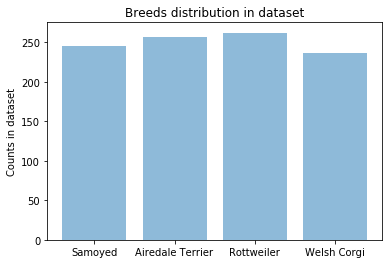

In [46]:
unique_breeds = data['Breed Name'].unique()
breed_count = np.zeros(len(unique_breeds))

for i in range(len(unique_breeds)):
    breed_count[i] = data[data['Breed Name'] == unique_breeds[i]]['Breed Name'].count()
    
plt.bar(unique_breeds, breed_count, align='center', alpha=0.5)
plt.ylabel('Counts in dataset')
plt.title('Breeds distribution in dataset')    

Let's replace the string values with numerical values:

In [47]:
for column_name in data.columns:
    if data[column_name].dtype == object:
        replace_map = {}
        unique_vals = data[column_name].unique()
        for i in range(len(unique_vals)):
            replace_map[unique_vals[i]] = i
        data[column_name] = data[column_name].map(replace_map)
        
data.sample(3)

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
531,3,14965.5722,34.0539,10.4033,0,0,1,0,332
954,1,20507.7247,57.1483,11.2490,1,0,0,0,502
409,2,54232.1214,66.9129,10.6473,2,0,0,0,270


In [48]:
missing_vals_cols = [col for col in data.columns if data[col].isnull().any()]
print(missing_vals_cols)

['Height(cm)']


We can actually use linear regression to predict the missing heights.

In [49]:
fill_in_missing_values(data, missing_vals_cols[0])

We inspect the correlation between our variables, as this might provide useful insights about our data:

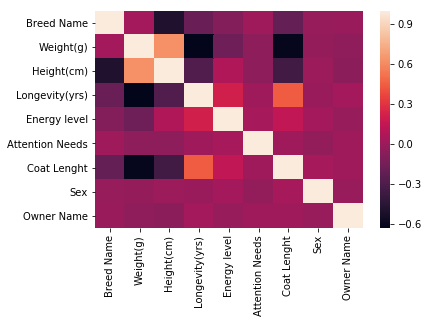

In [50]:
corr = data.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

We notice that there is a strong correlation between certain variables, such as Rottweiler and weight or terrier and high energy level, things that we'd expect to happen.

# Task 1. Classification

## Task 1.1 KNN classification

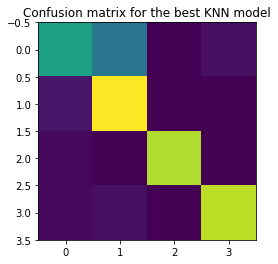

[0.74, 0.83, 0.825, 0.835, 0.835, 0.84, 0.84, 0.855, 0.845]


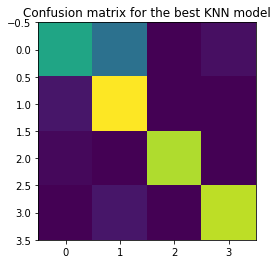

[0.76, 0.82, 0.82, 0.855, 0.85, 0.855, 0.845, 0.86, 0.85]


In [67]:
kLabel = 'Breed Name'    # This is the label we want to predict

# remap, cnt = {}, 0
# for breed in unique_breeds:
#     remap[breed] = cnt
#     cnt += 1

# print(data.sample(3).values)
# data.sample(3)
X_train, y_train, X_test, y_test = get_data(data, kLabel, ['Longevity(yrs)'], 0.8)

min_num_neigh, max_num_neigh = 2, 10
for dist_type in ['euclidean', 'manhattan']:
    best_model = {}
    accs = []
    for num_neighs in range(min_num_neigh, max_num_neigh + 1):
        knn = KNN(K=num_neighs, dist_type=dist_type)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc, confusion_matrix = compute_accuracy(y_test, y_pred)
        accs.append(acc)
        if len(best_model) == 0 or acc > best_model['acc']:
            best_model['acc'] = acc
            best_model['model'] = knn
            best_model['confusion'] = confusion_matrix
            
    plt.plot(range(min_num_neigh, max_num_neigh+1), accs)
    plt.clf()

    plt.imshow(best_model['confusion'])
    plt.title('Confusion matrix for the best KNN model')
    plt.show()

    print(accs)

## Task 2.2 Logistic regression classification
### TBD

# Task 2. Regression

In [71]:
# Store the means and standard deviations of the normalized columns to use them
# later to unnormalize the data.
means, stds = {}, {}
for column_name in ['Weight(g)', 'Height(cm)', 'Longevity(yrs)']:
    means[column_name] = data[column_name].mean()
    stds[column_name] = data[column_name].std()
    data[column_name] = (data[column_name] - means[column_name]) / stds[column_name]
    
data.sample(n=5)

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
199,3,-1.025303,-1.314504e-16,0.650939,0,0,2,1,47
268,1,-0.440997,4.478889e-01,0.964307,1,0,1,0,93
319,2,1.882526,1.036690e+00,-1.039308,0,0,0,1,0
4,0,-0.362198,1.158993e-01,-0.301422,2,0,2,0,4
54,2,1.946154,1.132487e+00,-0.939094,0,0,0,1,52


## Task 2.1. Linear regression

In [73]:
kLabel = 'Longevity(yrs)'
best_model = grid_search(data, kLabel, ['Breed Name', 'Owner Name'], means, stds, [None, 'ridge', 'lasso'], 
                         list(np.linspace(0.0001, 5, 10)), list(np.linspace(0.001, 0.2, 10)))

Train X shape:  (800, 7)
Train y shape:  (800, 1)
Test X shape:  (200, 7)
Test y shape:  (200, 1)
Best model is {'rms_err': 0.4727476658184104, 'sq_err': 22.349035553675538, 'reg': None, 'pen': 0.0001, 'lr': 0.001, 'model': <regression.LinearRegression object at 0x7f25fb066438>, 'l1_err': 0.35703451905870165}
Best model is {'rms_err': 0.03879821532819452, 'sq_err': 0.15053015126529481, 'reg': None, 'pen': 0.0001, 'lr': 0.023111111111111114, 'model': <regression.LinearRegression object at 0x7f25fb066c88>, 'l1_err': 0.02397480189354595}
Best model is {'rms_err': 0.004242335973429488, 'sq_err': 0.001799741451145392, 'reg': None, 'pen': 0.0001, 'lr': 0.045222222222222226, 'model': <regression.LinearRegression object at 0x7f25fb066438>, 'l1_err': 0.0028729899338697006}
Best model is {'rms_err': 7.428176533455344e-05, 'sq_err': 5.517780661217665e-07, 'reg': None, 'pen': 0.0001, 'lr': 0.06733333333333334, 'model': <regression.LinearRegression object at 0x7f25fb066c88>, 'l1_err': 4.52768374407

In [75]:
print('Best model squared error: {}'.format(best_model['sq_err']))
print('Best model RMS error: {}'.format(best_model['rms_err']))
print('Best model L1 error: {}'.format(best_model['l1_err']))

Best model squared error: 6.529782759675075e-18
Best model RMS error: 2.55534396112834e-10
Best model L1 error: 1.745442742250025e-10


## Task 2.2. KNN Regression

53.78436208557187
0.7333782249669802
0.5476623635075555


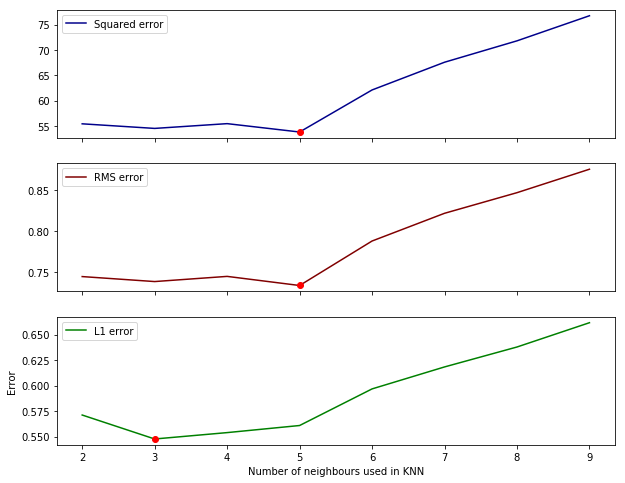

In [79]:
X_train, y_train, X_test, y_test = get_data(data, kLabel, ['Breed Name'], 0.8)

min_num_neigh, max_num_neigh = 2, 10
ks = range(min_num_neigh, max_num_neigh)
squared_errs, rms_errs, abs_errs = [], [], []
for num_neighs in ks:
    knn_regr = KNNRegression(K=num_neighs)
    knn_regr.fit(X_train, y_train)
    y_pred = knn_regr.predict(X_test)

    unnormalized_test_y = unnormalize(
            y_test, means[kLabel], stds[kLabel])
    unnormalized_pred_y = unnormalize(
            y_pred, means[kLabel], stds[kLabel])

    squared_err, rms_err, abs_err = compute_error(unnormalized_test_y, unnormalized_pred_y)
    
    squared_errs.append(squared_err)
    rms_errs.append(rms_err)
    abs_errs.append(abs_err)

f, axarr = plt.subplots(3, sharex=True, figsize=(10, 8))
axarr[0].plot(ks, squared_errs, color='darkblue', label='Squared error')
axarr[1].plot(ks, rms_errs, color='maroon', label='RMS error')
axarr[2].plot(ks, abs_errs, color='green', label='L1 error')

plt.xlabel('Number of neighbours used in KNN')
plt.ylabel('Error')

mins = [(li.index(min(li)), min(li)) for li in [squared_errs, rms_errs, abs_errs]]
for i in range(3):
    axarr[i].legend()
    axarr[i].plot(min_num_neigh + mins[i][0], mins[i][1], 'ro')
    print(mins[i][1])